<a href="https://colab.research.google.com/github/sebastiantonn/phd/blob/main/chapter4/230915_unetv2_singleleaves_3label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
#from tensorflow import keras
#from keras import backend, models, utils, preprocessing, layers
#from keras.utils import array_to_img
#from tensorflow.keras.preprocessing import image
from keras.optimizers import Adam
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
#import h5py
import re
from sklearn.model_selection import train_test_split

In [ ]:
!pip install focal-loss
from focal_loss import BinaryFocalLoss
from focal_loss import SparseCategoricalFocalLoss



In [ ]:
# define paths
wdir = '/content/drive/MyDrive/PhD/UV-BGF/230627_unet-test_individual-leaves/'
input_dir = '/content/drive/MyDrive/PhD/UV-BGF/230627_unet-test_individual-leaves/singleleaf_images_allbatches_downsampled'
target_dir = '/content/drive/MyDrive/PhD/UV-BGF/230627_unet-test_individual-leaves/singleleaf_3labels_allbatches_downsampled'

# from paths define image files
input_img_paths = sorted([os.path.join(input_dir, fname)
                          for fname in os.listdir(input_dir)
                          if fname.endswith(".png")and not fname.startswith(".")])

target_paths = sorted([os.path.join(target_dir, fname)
                       for fname in os.listdir(target_dir)
                       if fname.endswith(".png") and not fname.startswith(".")])


In [ ]:
# set input parameters
img_size = (480, 480) # (height, width)
num_imgs = len(input_img_paths)

# set grayscale intensity cutoff for labels (0 = background, 1 = bremia)
px_cutoff = 1

In [ ]:
# Load images and masks and convert them to arrays. Also add another 4th axis to mask arrays.
input_imgs = [cv2.imread(img, 1) for img in input_img_paths]
input_imgs = np.array(input_imgs)
targets = [cv2.imread(mask, 0) for mask in target_paths]
targets = np.array(targets)
targets = np.expand_dims(targets, axis = 3)

In [ ]:
# Check dimensions of image and label arrays
print('Image array shape:', input_imgs.shape, '; Label array shape:', targets.shape)

Image array shape: (330, 480, 480, 3) ; Label array shape: (330, 480, 480, 1)


In [ ]:
# Normalize image data set so values are between 0 and 1
input_imgs = input_imgs / 255

In [ ]:
# Check dimensions of image and label arrays
print('Image array shape:', input_imgs.shape, '; Label array shape:', targets.shape)
print('Image array max value:', input_imgs.max(), '; Label array max value:', targets.max())

Image array shape: (330, 480, 480, 3) ; Label array shape: (330, 480, 480, 1)
Image array max value: 1.0 ; Label array max value: 2


In [ ]:
# Set seed and testsize to split data into train, test and validation data data
testsize = 0.2
seed = 42
# Split into train and test set
train_input_imgs, test_input_imgs, train_targets, test_targets = train_test_split(input_imgs, targets, test_size = testsize, random_state = seed)
# Split train into train and validation set
train_input_imgs, val_input_imgs, train_targets, val_targets = train_test_split(train_input_imgs, train_targets, test_size = testsize, random_state = seed)

In [ ]:
# Check dimensions of image and label arrays
print('Training image array shape:', train_input_imgs.shape, '; Training label array shape:', train_targets.shape)
print('Test image array shape:', test_input_imgs.shape, '; Test label array shape:', test_targets.shape)
print('Validation image array shape:', val_input_imgs.shape, '; Validation label array shape:', val_targets.shape)

Training image array shape: (211, 480, 480, 3) ; Training label array shape: (211, 480, 480, 1)
Test image array shape: (66, 480, 480, 3) ; Test label array shape: (66, 480, 480, 1)
Validation image array shape: (53, 480, 480, 3) ; Validation label array shape: (53, 480, 480, 1)


In [ ]:
# Transform labels into one-hot encoding
from keras.utils import to_categorical
train_targets = to_categorical(train_targets, num_classes=3)
val_targets = to_categorical(val_targets, num_classes=3)
test_targets = to_categorical(test_targets, num_classes=3)

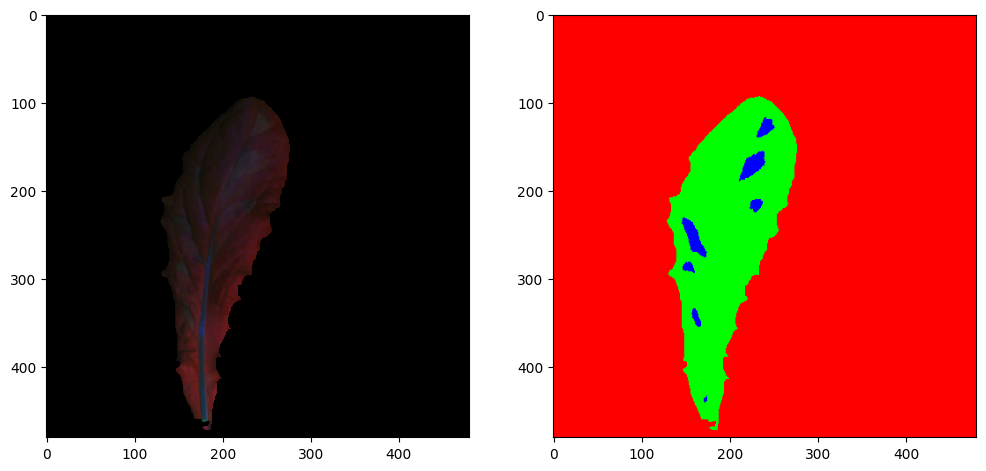

In [ ]:
# Check if images and labels match. To display the normalized (divided by 255) images containing values between 0 and 1 correctly
# we have to set min and max values and interpolation in the imshow() function. ::-1 reverses the order of the color channels from BGR (cv2 format) to RGB
img_number = random.randint(0, len(train_input_imgs)-1)
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.imshow(train_input_imgs[img_number,:,:,::-1], vmin = 0, vmax = 2, interpolation='nearest')
plt.subplot(1,2,2)
plt.imshow(train_targets[img_number,:,:,:], cmap = 'gray')

In [ ]:

# STAGE 2: TRAIN U-NET MODEL

# define the CNN architecture
num_classes = 3
inputs = tf.keras.layers.Input((img_size[1], img_size[1], 3))

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(u9) # sigmoid for binary, else softmax


In [ ]:
# build model
# Focal loss: loss=BinaryFocalLoss(gamma=2), Binary crossentropy: loss='binary_crossentropy'
# Optimizer = Adam(learning_rate = 1e-3) - tried between 1e-3 and 1e-4.
# 6e-4, Focal2, batch 4, epoch 40 = 0.83
# 6e-4, Focal2, batch 4, epoch 50 = 0.82
# 6e-4, Focal1.5, batch 4, epoch 40 = 0.80
# 6e-4, binary, batch 4, epoch 40 = 0.80

# Binary classification
#model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5)]) #[tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)]
#model.summary()

# Three classes classification
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate = 8e-4),
              loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0), #tf.keras.losses.CategoricalFocalCrossentropy(),
              metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=3)])#[tf.keras.metrics.IoU(num_classes = 3, target_class_ids=[2])]) #[tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)]
model.summary()

In [ ]:
# define optimizer and loss, compile model; best epoch will be saved
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(wdir, 'bremia_segmentation.hdf5'), save_best_only = True)]

# train according to parameters indicated
history = model.fit(train_input_imgs, train_targets,
                    epochs = 80, callbacks = callbacks, batch_size =7,
                    validation_data = (val_input_imgs, val_targets))

In [ ]:
# plot loss over epochs
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

# plot iou over epochs
epochs = range(1, len(history.history["one_hot_mean_io_u"]) + 1)
binary_io_u = history.history["one_hot_mean_io_u"]
val_binary_io_u = history.history["val_one_hot_mean_io_u"]
plt.figure()
plt.plot(epochs, binary_io_u, "bo", label = "Training IOU")
plt.plot(epochs, val_binary_io_u, "b", label = "Validation IOU")
plt.title("Training and validation IOU")
plt.legend()

# plot accuracy over epochs
# epochs = range(1, len(history.history["accuracy"]) + 1)
# accuracy = history.history["accuracy"]
# val_accuracy = history.history["val_accuracy"]
# plt.figure()
# plt.plot(epochs, accuracy, "bo", label = "Training Accuracy")
# plt.plot(epochs, val_accuracy, "b", label = "Validation Accuracy")
# plt.title("Training and validation Accuracy")
# plt.legend()

In [ ]:
# load best model from history
model = tf.keras.models.load_model(os.path.join(wdir, 'bremia_segmentation.hdf5'))

In [ ]:
modelname = '230918_model_val-train-test_batchsize7_LR-8e-4_70epochs.h5'

In [ ]:
# save this model to file
model.save(os.path.join(wdir, modelname), save_format = "h5")

In [ ]:
# load pre-trained U-Net model from file
model = tf.keras.models.load_model(os.path.join(wdir, modelname))

Shape of expanded test image: (1, 480, 480, 3)
1/1 [==============================] - 0s 181ms/step
Shape of prediction: (1, 480, 480, 3)
Shape of prediction after argmax (480, 480)
Unique values in prediction image: [0 1 2]


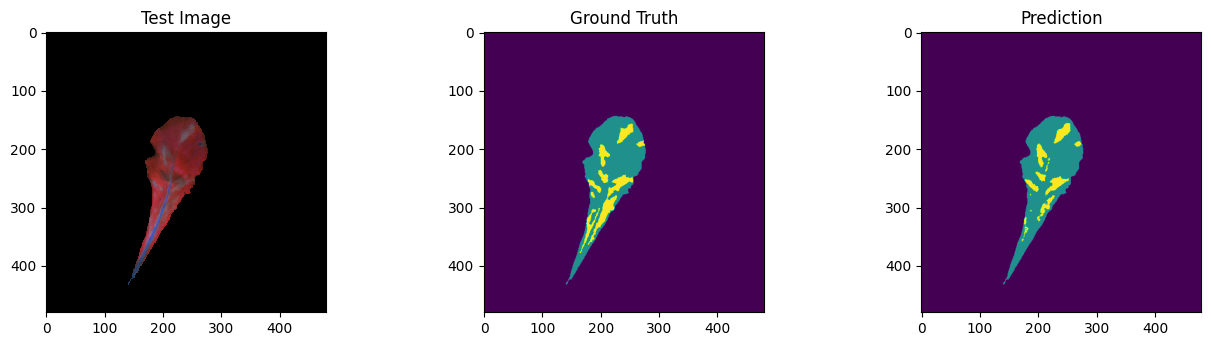

In [ ]:
# Check predictions for a random image out of the validation set

# Generate random number
img_number = random.randint(0, len(test_input_imgs)-1)
# Load validation image with random number
test_image = test_input_imgs[img_number]
# Load corresponding ground truth (label) with random number
ground_truth = test_targets[img_number]
# Add axis 0 to image and check shape (this needs to be done because model.predict() expects the format with 4 axis)
test_image_expanded = np.expand_dims(test_image, 0)
print('Shape of expanded test image:', test_image_expanded.shape)
# Predict image
prediction = model.predict(test_image_expanded)
# Check shape of prediction (this is now one hot encoded with the probability for each class on a separate 'channel' on the 3rd axis)
print('Shape of prediction:', prediction.shape)
# Revert one-hot encoding. Pixels get a value of 0, 1 or 2 (in case of three classes), depending on the highest probability on the 3rd axis.
# We also drop the first axis by adding [0,:,:], resulting in a 480 x 480 array, i.e. gray scale image with values 0, 1, or 2.
prediction = np.argmax(prediction, axis=3)[0,:,:]
# Check shape of prediction after argmax
print('Shape of prediction after argmax', prediction.shape)
# Check values in prediction
print('Unique values in prediction image:', np.unique(prediction))

# Create plots to show original image, ground truth and prediction side by side
plt.close(1)
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Test Image')
plt.imshow(test_image[:,:,::-1], vmin = 0, vmax = 1, interpolation='nearest')
plt.subplot(2,3,2)
plt.title('Ground Truth')
# Here we also revert the one-hot encoding of the ground truth to get a gray scale image, so we can use the same cmap as for the prediction.
plt.imshow(np.argmax(ground_truth, axis = 2), vmin = 0, vmax = 2, cmap = 'viridis') # Define min and max so the color mapping is the same also if there are only pixel values 0 and 1
plt.subplot(2,3,3)
plt.title('Prediction')
plt.imshow(prediction, vmin = 0, vmax = 2, cmap = 'viridis' )


In [ ]:
# predict validation set and revert one-hot encoding
pred = model.predict(test_input_imgs)
pred_argmax = np.argmax(pred, axis=3)

# Revert one-hot encoding of validation labels
test_targets_argmax = np.argmax(test_targets, axis = 3)


3/3 [==============================] - 8s 2s/step


In [ ]:
# Calculate Intersection-Over-Union (IOU) for validation set
# iou = true_positives / (true_positives + false_positives + false_negatives)
from tensorflow.keras.metrics import MeanIoU
iou = MeanIoU(num_classes=3)
iou.update_state(test_targets_argmax, pred_argmax)
print("Mean IoU =", iou.result().numpy())

Mean IoU = 0.8357951


In [ ]:
# Calculate I0U for each class
values = np.array(iou.get_weights()).reshape(3, 3) # number_of_classes, number_of_classes
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[1.4515152e+07 1.0000000e+00 4.0000000e+00]
 [3.0000000e+00 4.3071700e+05 4.4652000e+04]
 [0.0000000e+00 4.0625000e+04 1.7524600e+05]]
IoU for class1 is:  0.99999946
IoU for class2 is:  0.8347261
IoU for class3 is:  0.67265964


In [ ]:
# STAGE 3: SEGMENT NEW IMAGES

# load pre-trained U-Net model from file
model = tf.keras.models.load_model(os.path.join(wdir, '230918_model_batchsize7_LR-8e-4_70epochs.h5'))

1/1 [==============================] - 0s 111ms/step


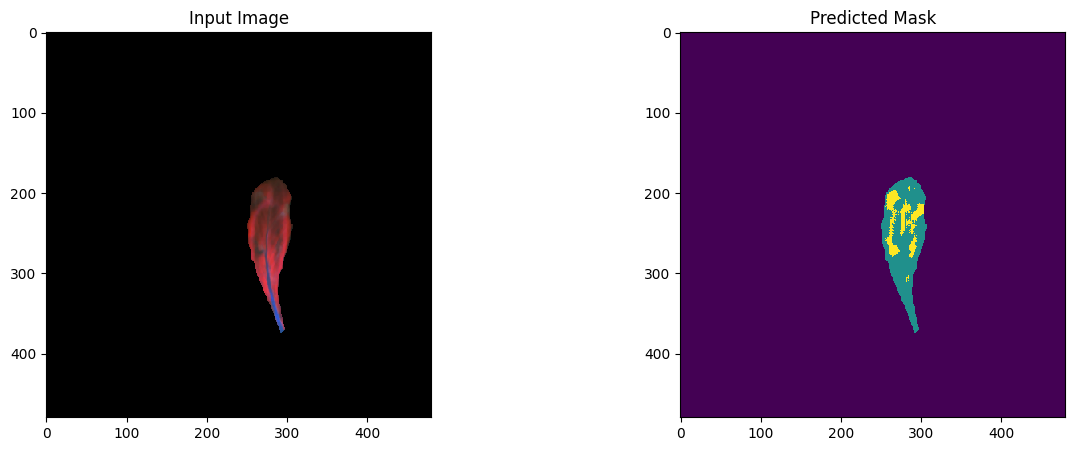

In [ ]:


# define path to new images, and image size
newdata_dir = '/content/drive/MyDrive/PhD/UV-BGF/230627_unet-test_individual-leaves/batch4_individualleaves_downsampled'
newdata_paths = sorted([os.path.join(newdata_dir, fname)
                        for fname in os.listdir(newdata_dir)
                        if fname.endswith(".png")])
img_size = (480, 480) # (height, width)

# Load images and convert them to arrays.
newdata_imgs = [cv2.imread(img, 1) for img in newdata_paths]
newdata_imgs = np.array(newdata_imgs)

# Normalize image data set so values are between 0 and 1
newdata_imgs = newdata_imgs / 255

# create new directories for mask and figure outputs to save to
export_dir = '/content/drive/MyDrive/PhD/UV-BGF/230627_unet-test_individual-leaves/230918_model_batchsize7_LR-8e-4_70epochs_batch4'
if not os.path.isdir(export_dir):
        os.mkdir(export_dir)

prediction_dir = os.path.join(export_dir, 'predictions')
if not os.path.isdir(prediction_dir):
        os.mkdir(prediction_dir)

figure_dir = os.path.join(export_dir, 'figures')
if not os.path.isdir(figure_dir):
        os.mkdir(figure_dir)

# apply model to all new images and save mask as image where 0 = background, 125 = uninfected leaf area, 250 = infected leaf area
for i in list(range(0, len(newdata_imgs)-1)):
    new_image = newdata_imgs[i]
    prediction = model.predict(np.expand_dims(new_image, 0))
    mask = np.argmax(prediction, axis=3)[0,:,:]
    mask_img = mask * 125
    mask_img = Image.fromarray(mask_img.astype("uint8"))
    mask_img.save(re.sub(newdata_dir, prediction_dir, newdata_paths[i]))

    # optional: plot side-by-side input vs predicted mask
    plt.close(1)
    fig = plt.figure(1, figsize = (15,5))
    plt.subplot(1,2,1)
    plt.imshow(new_image[:,:,::-1], vmin = 0, vmax = 1, interpolation='nearest')
    plt.title('Input Image')
    plt.subplot(1,2,2)
    plt.imshow(mask, vmin=0, vmax=2, cmap = 'viridis', interpolation='none')
    plt.title('Predicted Mask')
    fig.savefig(re.sub(newdata_dir, figure_dir, newdata_paths[i]), dpi = 150)


In [ ]:
# Script to calculate % UV-BGF from labels generated by CNN and the images used as input for the CNN

import pandas as pd

inputdir = prediction_dir

# Create empty list to be filled with the label pixel counts and percent uv-bgf per image
d=[]

for filename in os.listdir(inputdir):
        if '.png' in filename:
            # Print out filename of currently processed image
            print('Processing image: ' + filename)
            labelimgpath = os.path.join(inputdir, filename)
            labelimg = np.array(cv2.imread(labelimgpath, 0))
            leafpixels = np.count_nonzero(labelimg == 125)
            bgfpixels = np.count_nonzero(labelimg == 250)
            percent_bgf = round(bgfpixels/(bgfpixels+leafpixels) * 100, 2)
            #labelimg = np.array(Image.open(labelimgpath).convert('L'))
            #labelpixels_uncorrected = np.count_nonzero(labelimg)
            # Append current image filename and calculated parameters to list d
            d.append(
                {
                    'imagefile': filename,
                    'leaf_pixels': leafpixels,
                    'bgf_pixels': bgfpixels,
                    'percent_bgf': percent_bgf
                    })
# Convert list d to dataframe and save as CSV file in the input directory
df = pd.DataFrame(d)
outfile = os.path.join(inputdir, 'labelpixel_quantification.csv')
df.to_csv(outfile, index=False)

Processing image: BL33_100_1_0000_UV_channel_0-2_leaf1_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_1_0000_UV_channel_0-2_leaf2_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_1_0000_UV_channel_0-2_leaf3_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_2_0000_UV_channel_0-2_leaf1_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_2_0000_UV_channel_0-2_leaf2_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_2_0000_UV_channel_0-2_leaf3_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_3_0000_UV_channel_0-2_leaf1_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_3_0000_UV_channel_0-2_leaf2_median_kernel7_maxbright100_resized.png
Processing image: BL33_100_3_0000_UV_channel_0-2_leaf3_median_kernel7_maxbright100_resized.png
Processing image: BL33_101_1_0000_UV_channel_0-2_leaf1_median_kernel7_maxbright100_resized.png
Processing image: BL33_101_1_0000_UV_channel_0-2_l